In this notebook we'll pull a few slices/scans from the dataset and start exploring segmentation of the lungs.

Why is this necessary?

Well think about the size a scan in terms of pixels -- a 37 slice scan that has 512 by 512 dimensions means that there are nearly ONE MILLION pixels in this single scan alone. We're asking alot of our eventual algorithm to be able to parse this much information in a meaningful way (or in a meaningful time horizon)

What we want is to do is feed the model just the (potentially) relevant area of interest. This is accomplished through segmentation, which tries to partition (segment) an image into its mutliple components. "To simplify and/or change the representation of an image into something that is more meaningful and easier to analyze" (https://en.wikipedia.org/wiki/Image_segmentation)

There are a ton of segmentation techniques floating around and we'll spend some time exploring a few here -- the end goal of this is to use a segmentation technique to generate a more usable dataset to begin modeling

In [1]:
#so much input for one scan
512*512*37

9699328

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from fastai2.vision.all import *
from fastai2.medical.imaging import *
from nbdev.showdoc import *
from IPython.display import Image
from skimage import measure
from skimage.morphology import disk, opening, closing
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
path.ls()

(#6) [Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/osic-pulmonary-fibrosis-progression.zip'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/sample_submission.csv')]

In [4]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [5]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [6]:
train_df.head(1)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker


In [7]:
test_df.head(1)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker


Let's get some of our helper fxns from the previous notebook

In [8]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

In [9]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [10]:
train_path.ls()

(#176) [Path('train/ID00232637202260377586117'),Path('train/ID00134637202223873059688'),Path('train/ID00093637202205278167493'),Path('train/ID00307637202282126172865'),Path('train/ID00364637202296074419422'),Path('train/ID00172637202238316925179'),Path('train/ID00335637202286784464927'),Path('train/ID00213637202257692916109'),Path('train/ID00392637202302319160044'),Path('train/ID00030637202181211009029')...]

In [11]:
one_scan_sorted = dcm_sort(train_path.ls()[19])
one_scan_sorted_hu = ct_transformed_hu(one_scan_sorted, replace=0)
len(one_scan_sorted)

64

Let's plot the slices in order before converting to hounsfield scale and then once it's converted

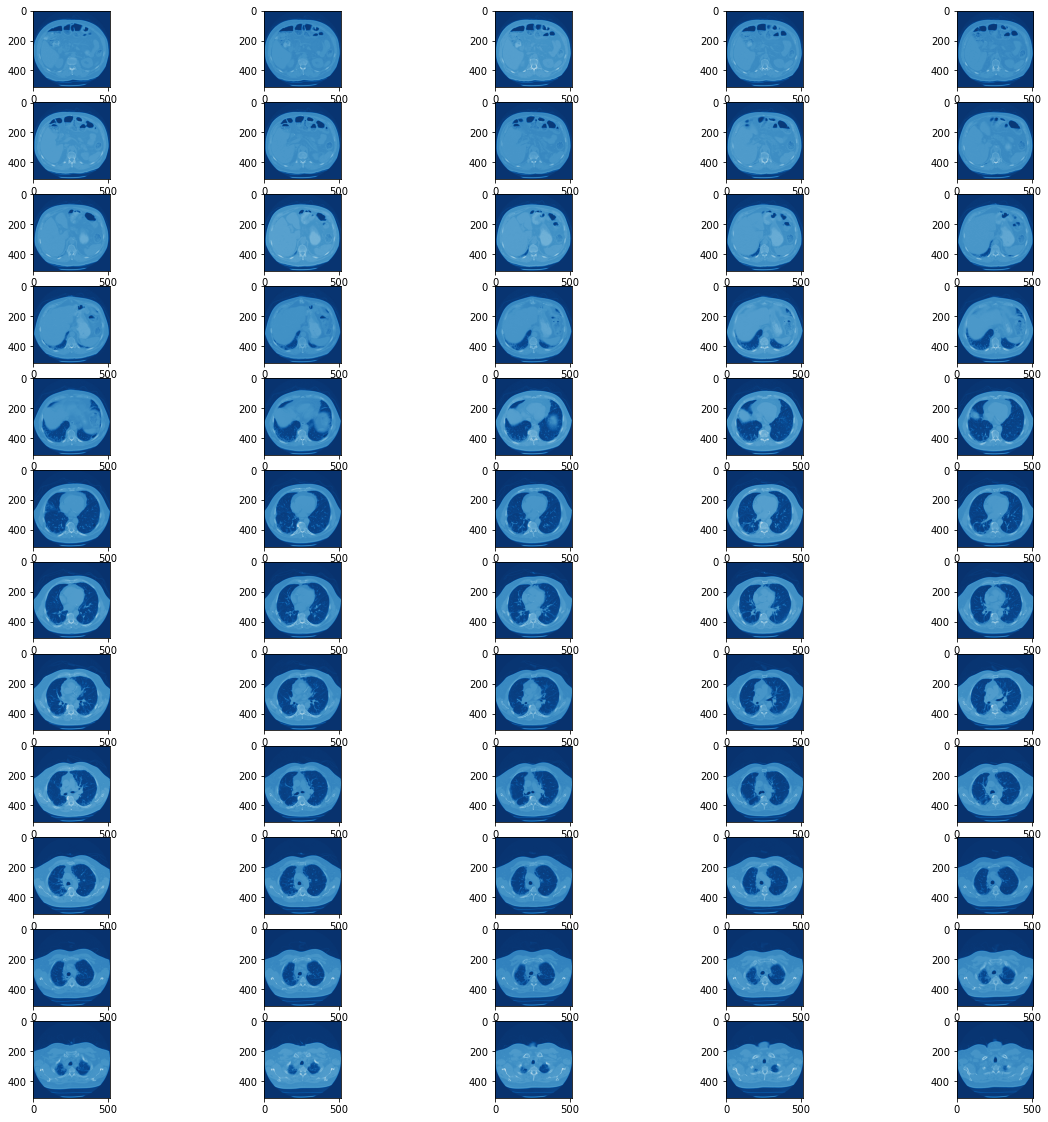

In [12]:
fig,ax = plt.subplots(12,5, figsize=(20,20))
for n in range(12):
    for m in range(5):
        ax[n,m].imshow(one_scan_sorted[n*5+m].pixel_array, cmap='Blues_r')

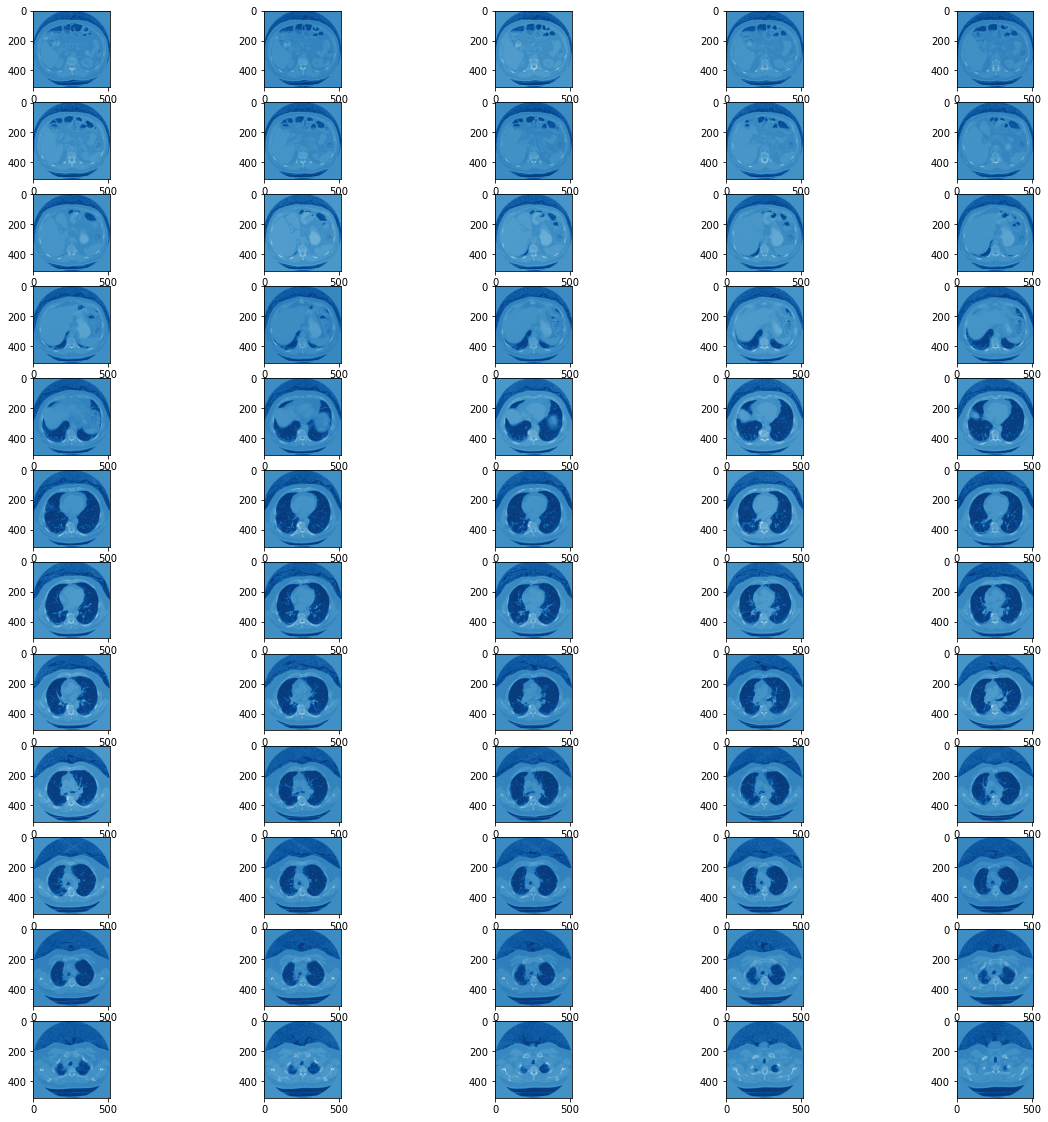

In [13]:
fig,ax = plt.subplots(12,5, figsize=(20,20))
for n in range(12):
    for m in range(5):
        ax[n,m].imshow(one_scan_sorted_hu[n*5+m], cmap='Blues_r')

Rather than working with all the slices -- let's concentrate on one

There's 60+ slices for this patient' scan, so pick a slice in the middle of that in order to get more lung --> as you approach the extremes, the amount of lung seen in each slice tapers off

In [32]:
one_slice = (one_scan_sorted[32]).pixel_array
img = one_scan_sorted_hu[32]

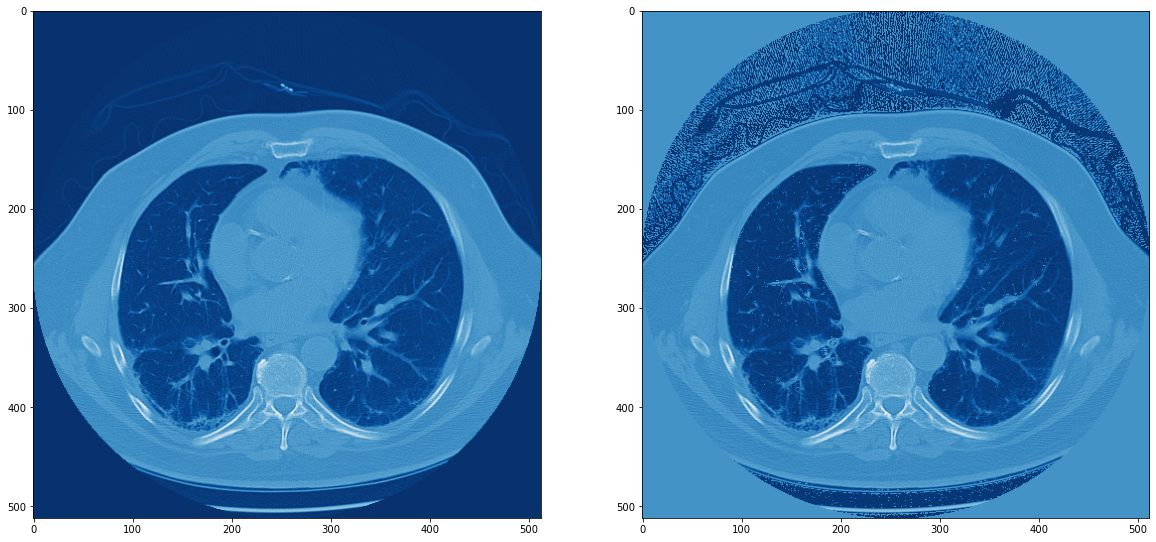

In [33]:
fig,ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(one_slice, cmap='Blues_r')
ax[1].imshow(img, cmap='Blues_r');

After our conversion: you can see that the border is now set to a the value of water (we chose zero as the replacement value in our resampling fxn before)

Let's also plot the distribution of pixel intensity for both slices:

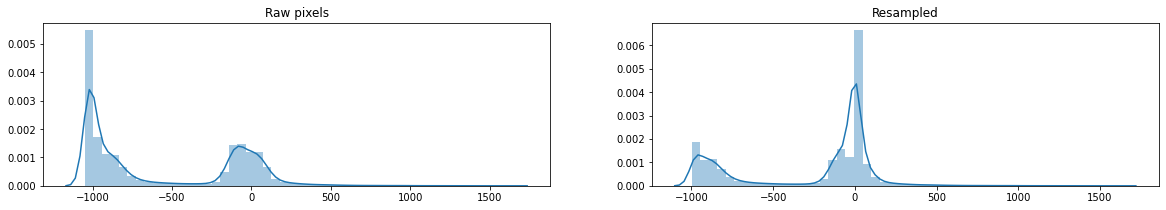

In [38]:
fig,ax = plt.subplots(1,2, figsize=(20,3))
sns.distplot(one_slice.flatten(), ax=ax[0]).set_title('Raw pixels')
sns.distplot(img.flatten(), ax=ax[1]).set_title('Resampled');

Just quickly take a look at the converted slice -- you can see that the four borders are filled with the zero values that we used as replacement

In [46]:
img.shape, type(img), img

((512, 512),
 numpy.ndarray,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16))

We know that lungs should be in the -400 to -600 range and that air should be around -1000. In order to start our segmentation, we want to identiy the areas of each slice that represent pixels of lung/air and set those to a different value relative to all other partso of the scan.

So here, we will set everything above a threshold to a value of 2 while everything below this value (ideally representing the lungs and air) will be set to 1. You can play around with the value chosen -- obviously you don't want to select something lower than -400, because then you might miss out on some lung tissue. Alot of people who have tried this technique have been keeping with the 320 value used in the guido ntoebook from the LUNA challenge. We'll go just a bit lower than that even.

Note: If you don't cast the "img > threshld" to a numpy array and declare the desired type - you will get an array with boolean values (because you are evaluating a boolean expression). We want to feed matplotlib numerical values and not booleans, so we cast it to an integer.

Not sure what the need of incrementing the return values by 1 is, since if you remove the increment the slice still looks the same

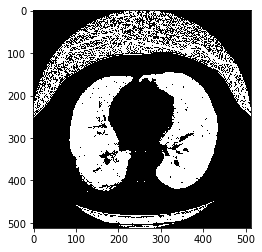

In [80]:
binary_img = np.array(img > -300, dtype=np.int16) + 1
plt.imshow(binary_img, cmap='binary', interpolation='nearest');

In [81]:
np.unique(binary_img), binary_img

(array([1, 2], dtype=int16),
 array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]], dtype=int16))

The label function in scikits measure.label package is doing the work here. It is simply labeling connected regions of an integer array.

One of it's (optional) parameters <u>background</u> considers all pixels with this value as background pixels and labels them as 0 --> defaults to zero

In [82]:
labels = measure.label(binary_img, background=2)
bg_label_1 = labels[0,0]
bg_label_2 = labels[0,-1]
bg_label_3 = labels[-1,0]
bg_label_4 = labels[-1,-1]
bg_label_1, bg_label_2, bg_label_3, bg_label_4

(0, 0, 0, 0)

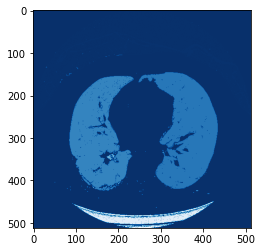

In [83]:
plt.imshow(labels, cmap='Blues_r');

In [85]:
binary_img_2 = binary_img.copy()
binary_img_2[bg_label_1 == labels] = 2
binary_img_2[bg_label_2 == labels] = 2
binary_img_2[bg_label_3 == labels] = 2
binary_img_2[bg_label_4 == labels] = 2

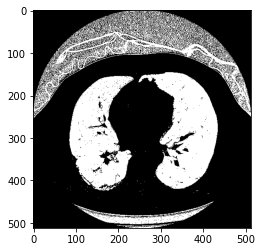

In [86]:
plt.imshow(binary_img_2, cmap='binary');

In [87]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        background_label_1 = labels[0,0]
        background_label_2 = labels[0,-1]
        background_label_3 = labels[-1,0]
        background_label_4 = labels[-1,-1]
    
        #Fill the air around the person
        binary_image[background_label_1 == labels] = 2
        binary_image[background_label_2 == labels] = 2
        binary_image[background_label_3 == labels] = 2
        binary_image[background_label_4 == labels] = 2
    
        #We have a lot of remaining small signals outside of the lungs that need to be removed. 
        #In our competition closing is superior to fill_lungs 
        selem = disk(4)
        binary_image = closing(binary_image, selem)
    
        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented

In [88]:
segmented = segment_lung_mask(one_scan_sorted_hu)
segmented.shape

(64, 512, 512)

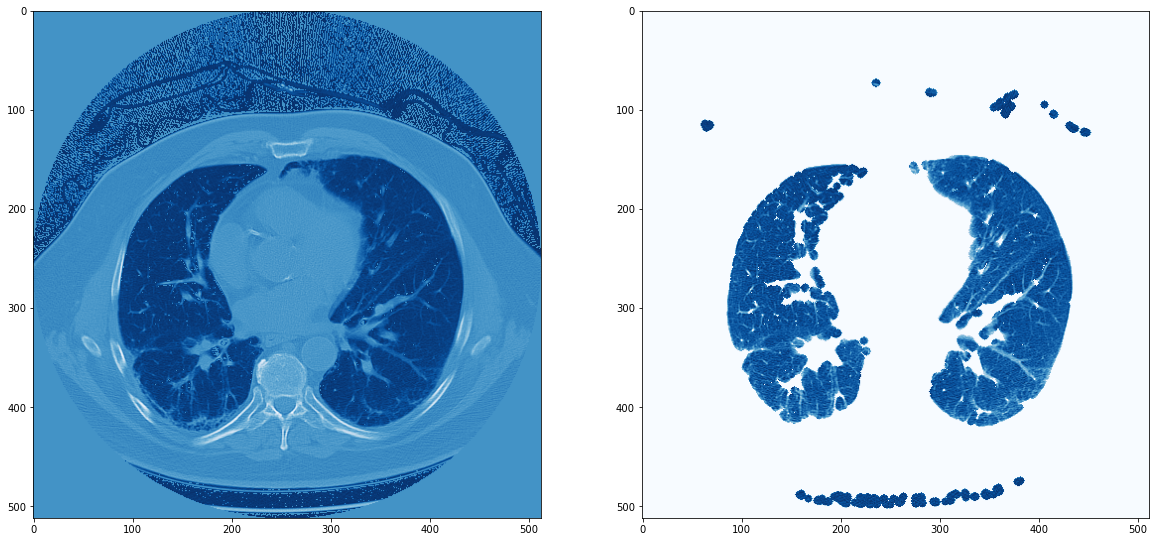

In [89]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(one_scan_sorted_hu[32], cmap="Blues_r")
ax[1].imshow(segmented[32], cmap="Blues_r");

In [28]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, 
                threshold, step_size=step_size, 
                method='lewiner', allow_degenerate=True) 
    return verts, faces

In [29]:
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    mesh.set_facecolor('b')
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()

Transposing surface
Calculating surface
Drawing


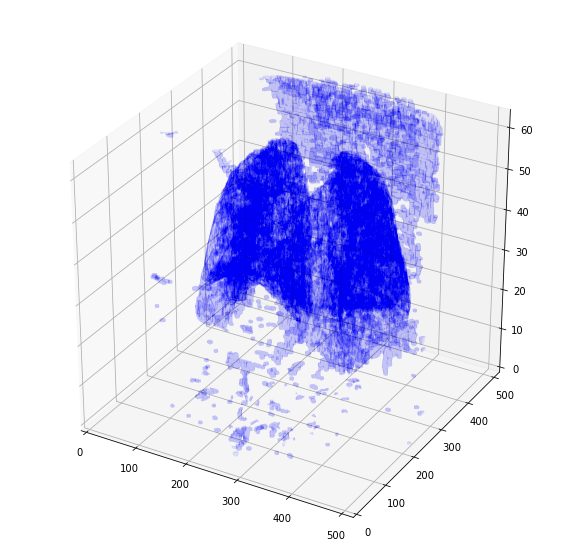

In [30]:
verts, faces = make_mesh(segmented, threshold=-700)
plt_3d(verts,faces)

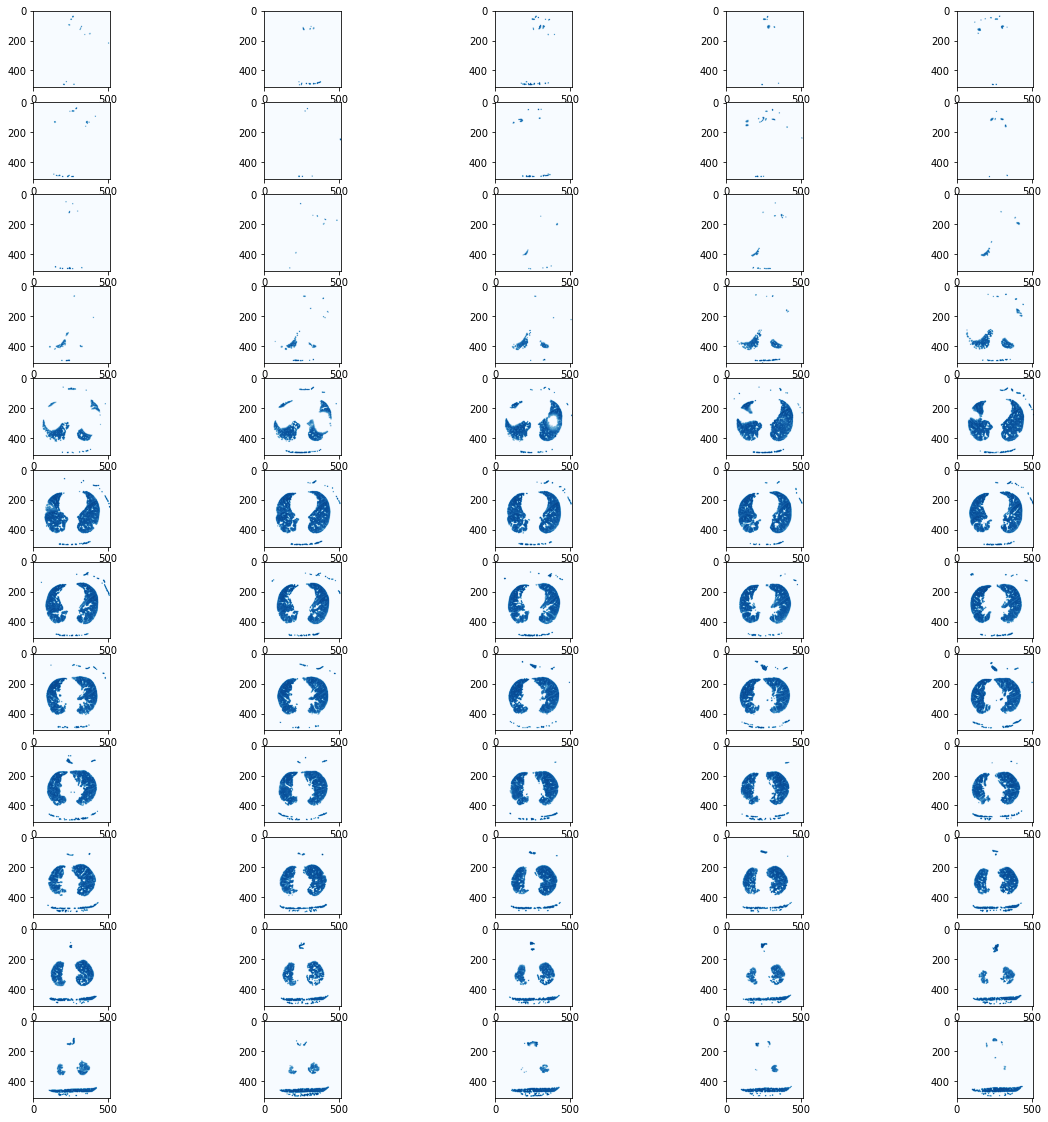

In [90]:
fig,ax = plt.subplots(12,5, figsize=(20,20))
for n in range(12):
    for m in range(5):
        ax[n,m].imshow(segmented[n*5+m], cmap='Blues_r')